# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1661.96914,1.00000
BTCUSDT,549.29105,0.33051
TRXUSDT,279.93914,0.16844
JASMYUSDT,234.87768,0.14132
SOLUSDT,224.32462,0.13498
OMUSDT,185.63409,0.11170
ETHUSDT,154.71713,0.09309
BBUSDT,33.16583,0.01996
BNBUSDT,0.01960,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

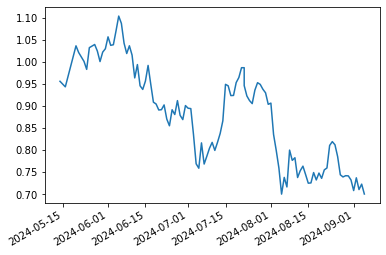

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.520358
BTCUSDT,0.400000
PEPEUSDT,0.060379
JASMYUSDT,0.019263


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.872001
OMUSDT,0.127999


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,549.291049,3.305062e-01,0.000000,0.000000
TRXUSDT,279.939140,1.684382e-01,0.872001,-0.703563
JASMYUSDT,234.877677,1.413249e-01,0.000000,0.000000
SOLUSDT,224.324616,1.349752e-01,0.000000,0.000000
OMUSDT,185.634087,1.116953e-01,0.127999,-0.016304
ETHUSDT,154.717131,9.309266e-02,0.000000,0.000000
BBUSDT,33.165834,1.995575e-02,0.000000,0.000000
BNBUSDT,0.019603,1.179482e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.689711e-10,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,549.291049,3.305062e-01,0.400000,-0.069494
TRXUSDT,279.939140,1.684382e-01,0.000000,0.000000
JASMYUSDT,234.877677,1.413249e-01,0.019263,0.122062
SOLUSDT,224.324616,1.349752e-01,0.000000,0.000000
OMUSDT,185.634087,1.116953e-01,0.520358,-0.408663
ETHUSDT,154.717131,9.309266e-02,0.000000,0.000000
BBUSDT,33.165834,1.995575e-02,0.000000,0.000000
BNBUSDT,0.019603,1.179482e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.689711e-10,0.060379,-0.060379


# Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

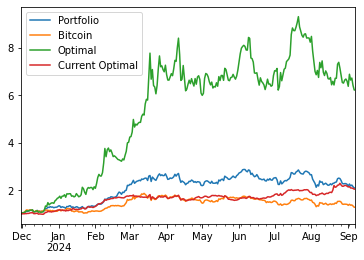

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

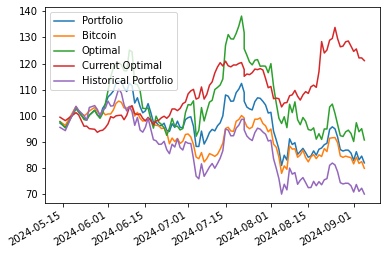

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-27,87.114047,84.688642,92.437184,126.403657,74.455873
2024-08-28,86.541675,84.145117,92.108381,126.656929,73.972108
2024-08-29,86.915243,84.605822,93.887571,128.310399,74.250621
2024-08-30,86.888056,84.270178,94.534655,128.615792,74.210191
2024-08-31,85.783500,84.056109,93.271227,126.658358,73.287799
2024-09-01,82.983036,81.638368,90.191677,124.648277,70.888670
2024-09-02,86.300442,84.205189,97.384114,125.584554,73.774701
2024-09-03,83.204375,81.830358,93.932662,122.146297,71.119955
2024-09-04,84.619088,82.515248,95.109580,122.169406,72.341855
2024-09-05,82.013981,79.925891,90.766594,121.116149,70.104808


<AxesSubplot:>

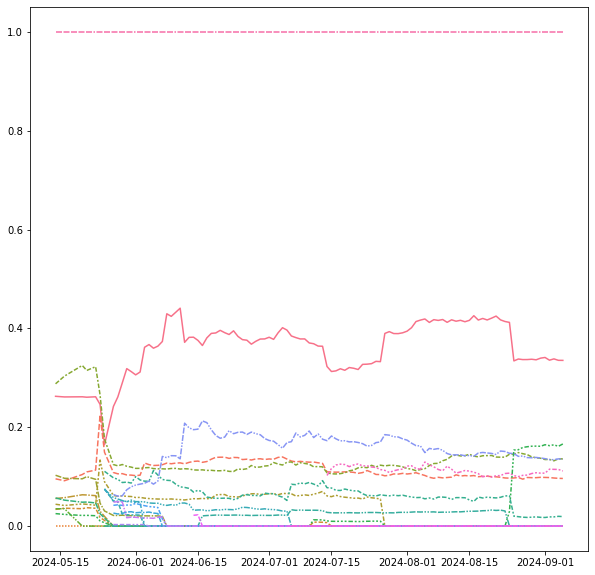

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

## Volatilities

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.789016
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.485209
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.481319
Bitcoin            0.450343
Optimal            0.790385
Current Optimal    0.336312
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.25751714617254945

## Risk Contribution

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.014236,0.057903,0.137823,0.051943,0.085880
JASMYUSDT,0.002311,0.004230,0.009328,0.000738,0.008591
OMUSDT,0.972309,0.921151,0.809634,0.721413,0.088220
PEPEUSDT,0.011143,0.016716,0.043215,0.010178,0.033037


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.462142,0.314422,0.269198,0.087041,0.182157
TRXUSDT,-0.202242,0.226620,0.045406,0.013043,0.032363
JASMYUSDT,0.236396,0.127469,0.253624,0.090734,0.162890
SOLUSDT,0.247226,0.114295,0.164154,0.035745,0.128408
OMUSDT,-0.052721,0.135164,0.137373,0.040501,0.096872
ETHUSDT,0.211642,0.073184,0.088559,0.011472,0.077087
BBUSDT,0.097558,0.008845,0.041686,0.003918,0.037768


# Value At Risk

## Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06449051540834111, -0.09091174694198965)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05006723561443031, -0.06435763244579894)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012322
TRXUSDT     -0.001872
JASMYUSDT   -0.011330
SOLUSDT     -0.011060
OMUSDT      -0.009157
ETHUSDT     -0.001920
BBUSDT      -0.002048
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049709
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016934
TRXUSDT     -0.004241
JASMYUSDT   -0.014266
SOLUSDT     -0.010323
OMUSDT      -0.008541
ETHUSDT     -0.005842
BBUSDT      -0.002118
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062265
dtype: float64

## Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.08189656178994009, -0.1049687490694196)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05027546553728903, -0.0644392464224328)

## Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07555463140426984, -0.0969354019850801)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05091877576379457, -0.06353841608645075)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013846
TRXUSDT     -0.001762
JASMYUSDT   -0.013461
SOLUSDT     -0.009096
OMUSDT      -0.005894
ETHUSDT     -0.004447
BBUSDT      -0.002207
Portfolio   -0.050713
dtype: float64

## Copulas

### Gaussian Copula

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07346150396947267, -0.09403939269811869)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05115439997657313, -0.06451983934936019)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014024
TRXUSDT     -0.002671
JASMYUSDT   -0.012344
SOLUSDT     -0.008427
OMUSDT      -0.005872
ETHUSDT     -0.005054
BBUSDT      -0.002320
Portfolio   -0.050713
dtype: float64

### Student Copula

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07476732006045628, -0.09551964156758243)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05259093478258543, -0.06613373672252897)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013953
TRXUSDT     -0.002641
JASMYUSDT   -0.012936
SOLUSDT     -0.008168
OMUSDT      -0.007079
ETHUSDT     -0.004607
BBUSDT      -0.002282
Portfolio   -0.051666
dtype: float64

### Gumbel Copula

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1503089369353091, -0.2159487693740227)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05718392561498788, -0.07682707911142052)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.020301
TRXUSDT     -0.001871
JASMYUSDT   -0.016712
SOLUSDT     -0.009049
OMUSDT      -0.006997
ETHUSDT     -0.000944
BBUSDT      -0.000723
Portfolio   -0.056596
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08355965133461131, -0.1031516267045136)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.049882369316548526, -0.0639030000527319)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013691
TRXUSDT     -0.001955
JASMYUSDT   -0.013388
SOLUSDT     -0.008375
OMUSDT      -0.007377
ETHUSDT     -0.004363
BBUSDT      -0.002109
Portfolio   -0.051257
dtype: float64

## VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062799,-0.115160,-0.098076,-0.025088
2024-01-15,-0.062799,-0.115156,-0.095702,0.014654
2024-01-16,-0.062799,-0.116061,-0.097446,0.065097
2024-01-17,-0.062799,-0.118500,-0.097426,-0.037441
2024-01-18,-0.062799,-0.120628,-0.102614,-0.036125
...,...,...,...,...
2024-09-03,-0.058959,-0.094798,-0.095643,-0.035442
2024-09-04,-0.058959,-0.094571,-0.094183,0.012529
2024-09-05,-0.059050,-0.095768,-0.099001,-0.045663
2024-09-06,-0.059050,-0.094999,-0.095402,-0.030288


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026866,-0.076408,-0.068095,-0.017336
2024-05-29,-0.023733,-0.073971,-0.067286,-0.008414
2024-05-30,-0.023733,-0.063842,-0.059952,0.033233
2024-05-31,-0.023733,-0.062393,-0.055685,0.015257
2024-06-01,-0.023733,-0.062412,-0.054564,0.026451
...,...,...,...,...
2024-09-03,-0.049314,-0.067559,-0.070724,-0.035875
2024-09-04,-0.049314,-0.068440,-0.070068,0.017003
2024-09-05,-0.049314,-0.069635,-0.075810,-0.030786
2024-09-06,-0.049314,-0.070338,-0.076597,-0.026207


<AxesSubplot:>

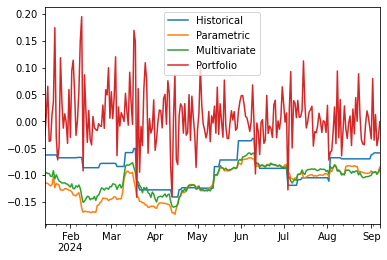

In [72]:
var_data.plot()

<AxesSubplot:>

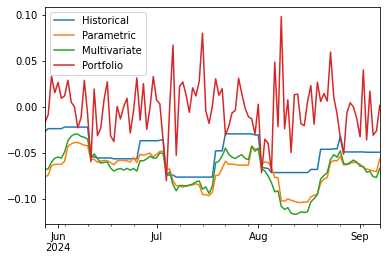

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021008,0.008403,0.012605
Kupiec Stat,5.337456,13.093724,9.878267
P-value,0.020872,0.000296,0.001672


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.07767,0.038835,0.029126
Kupiec Stat,1.430945,0.291844,1.104592
P-value,0.23161,0.589041,0.293261


## Principal Component Analysis

### Historical PCA

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78891386, 0.06474066, 0.05332232, 0.04853546, 0.04448769])

In [77]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023699
AAVEUSDT        0.013921
ADAUSDT         0.014035
ALGOUSDT        0.015500
APTUSDT         0.014627
                  ...   
WLDUSDT         0.021100
XECUSDT         0.015025
XLMUSDT         0.009436
XRPUSDT         0.009095
XTZUSDT         0.014137
Name: PC1, Length: 66, dtype: float64

<AxesSubplot:>

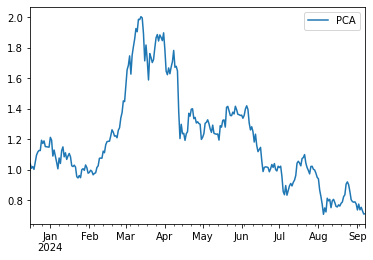

In [78]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

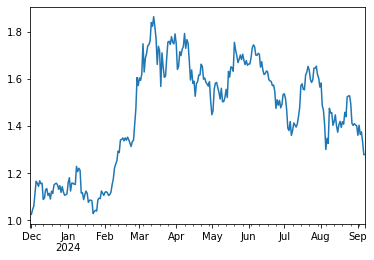

In [79]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [80]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA             0.000000
SANDUSDT        0.298168
ADAUSDT         0.324379
XTZUSDT         0.329721
ALGOUSDT        0.344427
                  ...   
1000SATSUSDT    0.972715
PEPEUSDT        0.991941
FLOKIUSDT       1.000436
WLDUSDT         1.016709
OMUSDT          1.303561
Length: 67, dtype: float64

<AxesSubplot:>

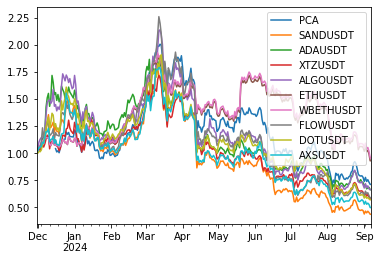

In [81]:
(1+comparison[distances.index[:10]]).cumprod().plot()

### Current PCA

In [82]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67029929, 0.14046302, 0.08378071, 0.07285648, 0.0326005 ])

In [83]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063058
TRXUSDT      0.015586
JASMYUSDT    0.155909
SOLUSDT      0.102921
OMUSDT       0.100093
ETHUSDT      0.085609
BBUSDT       0.247662
BNBUSDT      0.068023
PEPEUSDT     0.161138
Name: PC1, dtype: float64

<AxesSubplot:>

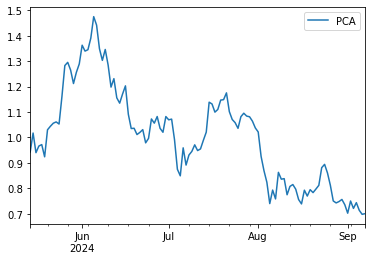

In [84]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

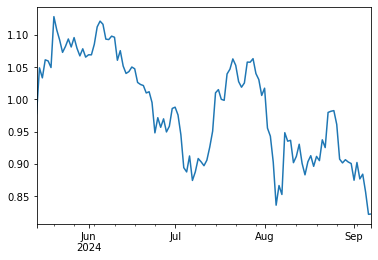

In [85]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [86]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.325649
SOLUSDT      0.335956
BNBUSDT      0.352525
BTCUSDT      0.358174
JASMYUSDT    0.417152
PEPEUSDT     0.452096
OMUSDT       0.506417
TRXUSDT      0.526603
BBUSDT       0.604735
dtype: float64

<AxesSubplot:>

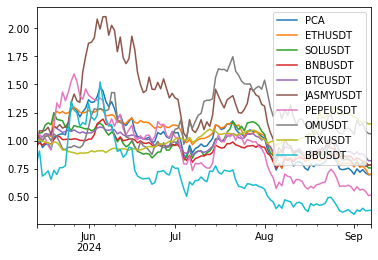

In [87]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [88]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.950784
BBUSDT       1.738339
JASMYUSDT    1.283039
SOLUSDT      1.170479
BTCUSDT      1.000000
OMUSDT       0.997073
ETHUSDT      0.957038
BNBUSDT      0.670473
TRXUSDT      0.287742
Name: BTCUSDT, dtype: float64

In [89]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.947439
PEPEUSDT     1.866827
ETHUSDT      1.443969
OMUSDT       1.428543
SOLUSDT      1.321272
BTCUSDT      1.000000
JASMYUSDT    0.862233
BNBUSDT      0.573957
TRXUSDT      0.380850
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [93]:
results={}
window=15

for i in range(0,ex_ante_perf_to_use.shape[0],window):
    
    try:
        
        if i+window>ex_ante_perf_to_use.shape[0]:
            
            dataset=ex_ante_perf_to_use.iloc[i:-1]
            risk=RiskAnalysis(dataset)
            date=ex_ante_perf_to_use.iloc[i:-1].index[-1]
            optimal=risk.optimize(objective='sharpe_ratio')

        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=ex_ante_perf_to_use.iloc[i:i+window].index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,OMUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-28,0.000000,0.000000,0.600325,0.004690,0.000000,0.0,0.0,0.0,0.394985
2024-06-12,0.000000,0.848841,0.151159,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-06-27,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-07-12,0.000000,0.851742,0.000000,0.000000,0.148258,0.0,0.0,0.0,0.000000
2024-07-27,0.525106,0.000000,0.000000,0.474894,0.000000,0.0,0.0,0.0,0.000000
2024-08-11,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-08-26,0.000000,0.470877,0.000000,0.529123,0.000000,0.0,0.0,0.0,0.000000
2024-09-07,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
